# Exponential Mechanism Quantiles

This section explains the algorithm used to release a differentially private quantile using the exponential mechanism in the OpenDP Library.

Our data will just be 1000 samples from the gaussian distribution.

In [1]:
import numpy as np
data = np.random.normal(scale=10, size=1000)

The following algorithm approximately chooses the candidate nearest to the alpha-quantile.

In [2]:
import opendp.prelude as dp
dp.enable_features("contrib", "honest-but-curious")

space = dp.vector_domain(dp.atom_domain(T=float, nan=False)), dp.symmetric_distance()
candidates = np.linspace(-50, 50, 101).tolist()

m_median = space >> dp.m.then_private_quantile(
    dp.max_divergence(),
    candidates=candidates,
    alpha=0.5,
    scale=1.0
)
m_median(data)

0.0

The algorithm breaks down into three smaller steps:

In [3]:
m_median = (
    space
    # 1. transformation: compute a score for each candidate
    >> dp.t.then_quantile_score_candidates(candidates, alpha=0.5)
    # 2. measurement: privately select the index of the best score
    >> dp.m.then_report_noisy_max(dp.max_divergence(), scale=1.0, optimize="min")
    # 3. postprocessor: return the candidate with the selected index
    >> (lambda i: candidates[i])
)

m_median(data)

0.0

## 1. Score Each Candidate

The `quantile_score_candidates` transformation assigns scores to each candidate by the number of records between the candidate and true quantile.
The scoring is similar to golf, where scores closer to zero are considered better.

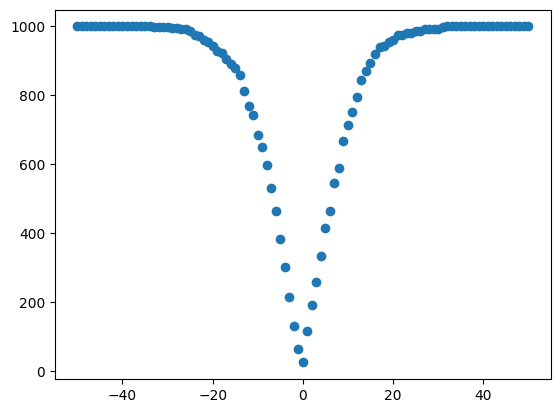

In [4]:
import matplotlib.pyplot as plt

# make the transformation get discrete scores per candidate
t_median_scores = dp.t.make_quantile_score_candidates(
    dp.vector_domain(dp.atom_domain(T=float, nan=False)), 
    dp.symmetric_distance(), 
    candidates, 
    alpha=0.5)

# plot the scores
scores = t_median_scores(data)
plt.scatter(candidates, scores);

Since the data was sampled with a mean of 50, candidates nearer to 50 get better scores.
The scores increase quickly away from 50 because the data is concentrated at 50.

The scoring transformation is considered stable because each score can change by no more than one, when one record is added or removed.
That is, when one new record is added, the number of records between a candidate and the true quantile can change by at most one.

In [5]:
t_median_scores.map(d_in=1)

1

The sensitivity of the score vector is based on the $L_\infty$ sensitivity, or the max change of any one score.

## 2. Report Noisy Min

We now pass the scores to the `make_report_noisy_max` measurement. 
The measurement adds exponential noise to each score, then returns index of the best score.
In our case, since better scores are smaller, we configure the mechanism to choose the min, not the max.

In [6]:
input_space = dp.vector_domain(dp.atom_domain(T=int)), dp.linf_distance(T=int)
m_select_score = dp.m.make_report_noisy_max(*input_space, dp.max_divergence(), scale=1.0, optimize='min')

#pass the discrete scores to the measurement
noisy_index = m_select_score(scores)
noisy_index

50

In [7]:
m_select_score.map(d_in=1)

2.0

The mechanism satisfies $\epsilon = 2$ when the $L_\infty$ sensitivity is one.
The mechanism is a specialized version of the exponential mechanism,
and accounts for the case where, for example, 
all scores increase by the sensitivity, except for one score that decreases by the sensitivity.
Since scores can change in different directions, it makes it twice as easy to distinguish between two adjacent datasets of scores.

The mechanism can also be calibrated to satisfy bounded range:

In [8]:
m_select_score = dp.m.make_report_noisy_max(*input_space, dp.range_divergence(), scale=1.0, optimize='min')

#pass the discrete scores to the measurement
noisy_index = m_select_score(scores)
noisy_index

50

The mechanism operates similarly, but adds noise from the gumbel distribution to each score.
This has several tradeoffs:
* Report noisy max with gumbel noise is exactly equivalent to the exponential mechanism
* The variance of the gumbel distribution is higher than the exponential distribution, which decreases the utility
* $\eta$ BR satisfies $\frac{\eta^2}{8}$ zCDP, whereas $\epsilon$ DP only satisfies $\frac{\epsilon^2}{2}$ zCDP. Therefore, consider parameterizing the mechanism with `dp.range_divergence()` (gumbel noise) when answering a large number of queries.

## 3. Index Candidates

Remember that this DP release is the index of the chosen candidate, _not_ the candidate itself.
In this case, since the fiftieth candidate should be right around zero.

We now create a postprocessor that maps the index to its corresponding candidate. 

In [9]:
postprocessor = lambda i: candidates[i]

## Floating-Point Attack Mitigation

The example above chose fortunate constants that made the analysis simple.
However, when the choice of alpha is more complex, the sensitivity gets much larger.
Take, for instance, if alpha is $1 / \sqrt{2}$.

In [10]:
# make the transformation get discrete scores per candidate
t_median_scores = dp.t.make_quantile_score_candidates(
    dp.vector_domain(dp.atom_domain(T=float, nan=False)), 
    dp.symmetric_distance(), 
    candidates, 
    alpha=1 / np.sqrt(2))
t_median_scores.map(d_in=1)

7071

In order to protect against floating-point attacks, OpenDP rationalizes alpha and multiplies the scores and the sensitivity by the denominator.
Notice how the sensitivity follows the first digits of alpha:

In [11]:
float(1 / np.sqrt(2))

0.7071067811865475

Since both the scores and the sensitivity are scaled up by the same amount, 
this mitigation has no effect on the utility of the algorithm.
On the other hand, this could make interpreting the scale parameter trickier.

Since the mitigation is not material to the interpretation of the algorithm,
`then_private_quantile` multiplies the scale parameter by the appropriate factor to conceal this mitigation.
